In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from yellowbrick.contrib.classifier import DecisionViz
from sklearn.decomposition import PCA
from itertools import product
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from yellowbrick.datasets import load_credit
from yellowbrick.features import PCA as yPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score 
from scikitplot.metrics import plot_precision_recall, plot_roc, plot_cumulative_gain, plot_lift_curve , plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, classification_report
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay
)
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train=pd.read_csv("../Dataset_prepared/Prepared_train.csv")
df_test=pd.read_csv("../Dataset_prepared/Prepared_test.csv")

In [4]:
df_train.drop('actor',axis=1,inplace=True)
df_train.drop('filename',axis=1,inplace=True)

df_test.drop('actor',axis=1,inplace=True)
df_test.drop('filename',axis=1,inplace=True)

In [5]:
c = df_train.select_dtypes(include=['object']).columns.tolist()

c

['vocal_channel',
 'emotion',
 'emotional_intensity',
 'statement',
 'repetition',
 'sex']

In [6]:
a =[x for x in c if x!='emotion']
a

['vocal_channel', 'emotional_intensity', 'statement', 'repetition', 'sex']

In [7]:
from sklearn import preprocessing
le=preprocessing.LabelEncoder()
c = df_train.select_dtypes(include=['object']).columns.tolist()
for i in a:
    df_train[i]=le.fit_transform(df_train[i])

for i in a:
    df_test[i]=le.fit_transform(df_test[i])
df_train['emotion']=le.fit_transform(df_train['emotion'])
df_test['emotion']=le.fit_transform(df_test['emotion'])    

In [8]:
le.classes_

array(['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad',
       'surprised'], dtype=object)

In [9]:
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler, OneHotEncoder

scaler = StandardScaler()
numeric_features = [n for n in df_train.columns if n!="emotion" and n!= "vocal_channel" and n!= "emotional_intensity" and n!= "statement" and n!= "repetition" and n!= "sex" and n!="filename" and n!="actor"]
scaled_features = scaler.fit_transform(df_train[numeric_features])
df_train[numeric_features] = scaled_features


scaled_features_test = scaler.transform(df_test[numeric_features])
df_test[numeric_features] = scaled_features_test



In [10]:
col=[x for x in df_train.columns if x!="emotion"]
X_train=df_train[col].values
y_train = np.array(df_train["emotion"])

In [11]:
X_test=df_test[col].values
y_test = np.array(df_test["emotion"])

FUNZIONI UTILI 

### LINEAR SVC

In [12]:
from sklearn.svm import LinearSVC


In [15]:
from sklearn.model_selection import GridSearchCV

#Set the parameters by cross-validation
param_grid = {
    'tol':(1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6),
    'C': (0.001, 0.05, 0.01, 0.1, 1.0, 10.0, 50, 100.0),
    'loss' : ["hinge", "squared_hinge"],
    'multi_class':["ovr","crammer_singer"]

}
# Set the parameters by cross-validation
grid = GridSearchCV(
    LinearSVC(),
    param_grid=param_grid,
    cv=StratifiedKFold(), # 
    refit=True,
    scoring="f1_macro",
    n_jobs=-1
)
grid.fit(X_train, y_train)
clf = grid.best_estimator_


In [16]:
print(grid.best_params_)

{'C': 0.05, 'loss': 'squared_hinge', 'multi_class': 'ovr', 'tol': 1e-05}


In [13]:
svm = LinearSVC(C = 0.05 ,loss= 'squared_hinge',multi_class='ovr' ,tol = 1e-05)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.55      0.76      0.64        96
           1       0.48      0.64      0.55        96
           2       0.45      0.69      0.54        48
           3       0.61      0.39      0.47        96
           4       0.37      0.39      0.38        96
           5       0.38      0.31      0.34        48
           6       0.42      0.17      0.24        96
           7       0.40      0.44      0.42        48

    accuracy                           0.47       624
   macro avg       0.46      0.47      0.45       624
weighted avg       0.47      0.47      0.45       624



PLOTTIAMO GRAFICI

In [14]:
def print_confMatrix(y_test,y_test_pred):
    cm=confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels =le.classes_)
    fig, ax = plt.subplots(figsize=(10,10))
    disp.plot(ax=ax, xticks_rotation='vertical',cmap='Greens')
    plt.show()

In [15]:
def print_rocCurve(clf,X_test,y_test):
    y_tmp=clf.predict_proba(X_test)
    plot_roc(y_test, clf.predict_proba(X_test),figsize=(10,6))
    plt.show()

In [16]:
def print_precrecCurve(clf,X_test,y_test):
    plot_precision_recall(y_test, clf.predict_proba(X_test),figsize=(10,7))
    plt.show()

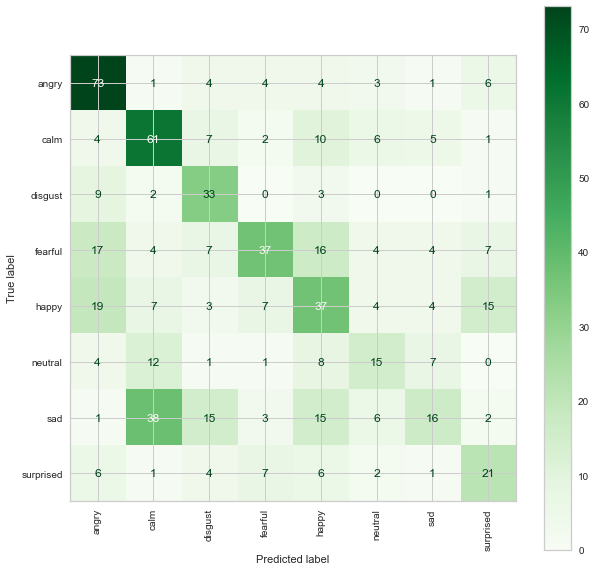

In [17]:
print_confMatrix(y_test,y_pred)

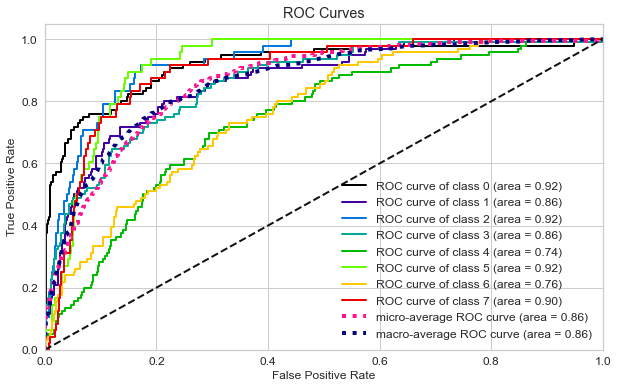

In [19]:
from sklearn.calibration import CalibratedClassifierCV

cclf = CalibratedClassifierCV(base_estimator=svm, cv=5)
cclf.fit(X_train, y_train)
y_pred = cclf.predict(X_test)
print_rocCurve(cclf,X_test,y_test)


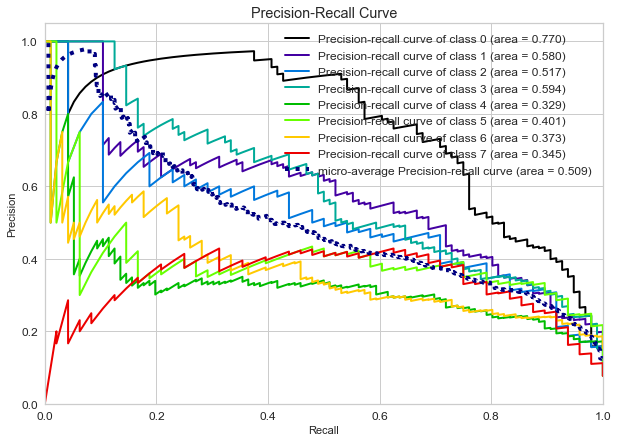

In [21]:
print_precrecCurve(cclf,X_test,y_test)

In [22]:
from sklearn.decomposition import PCA

In [23]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_train)

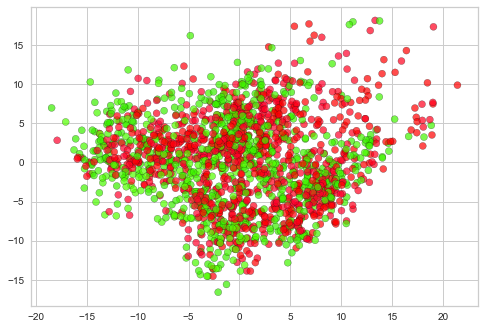

In [24]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Inserire i vettori

In [26]:
from sklearn.svm import SVC

NON LINEAR

In [32]:


# Set the parameters by cross-validation
param_grid = {
    'kernel' : ('linear', 'rbf', 'poly', 'sigmoid'),
    'C': (0.001, 0.05, 0.01, 0.1, 1.0, 10.0, 50, 100.0),
    'tol': (1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6),
    'decision_function_shape':["ovo", "ovr"]
    }


# Set the parameters by cross-validation
grid = GridSearchCV(
    SVC(),
    param_grid=param_grid,
    cv=StratifiedKFold(), # 
    refit=True,
    scoring="f1_macro",
    n_jobs=-1
)
grid.fit(X_train, y_train)
clf = grid.best_estimator_


In [33]:
print(grid.best_params_)

{'C': 0.1, 'decision_function_shape': 'ovo', 'kernel': 'linear', 'tol': 1.0}


              precision    recall  f1-score   support

           0       0.49      0.75      0.60        96
           1       0.46      0.61      0.53        96
           2       0.45      0.56      0.50        48
           3       0.55      0.38      0.45        96
           4       0.41      0.38      0.39        96
           5       0.45      0.48      0.46        48
           6       0.41      0.19      0.26        96
           7       0.55      0.48      0.51        48

    accuracy                           0.47       624
   macro avg       0.47      0.48      0.46       624
weighted avg       0.47      0.47      0.45       624



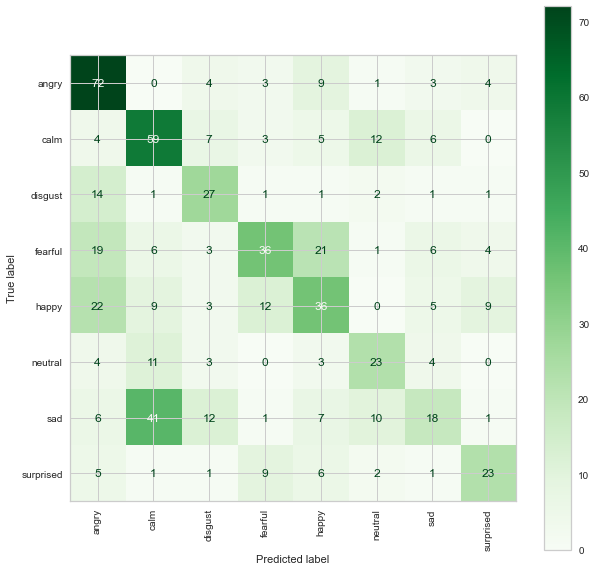

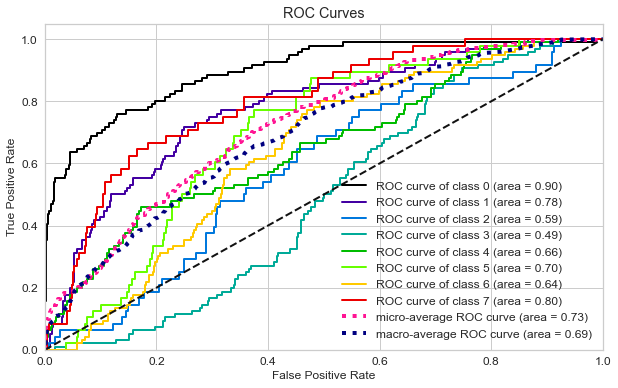

In [32]:
clf = SVC(C = 0.1  , kernel = 'linear', tol = 1.0,decision_function_shape='ovo')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))
print_confMatrix(y_test,y_pred)
cclf = CalibratedClassifierCV(base_estimator=clf, cv=5)
cclf.fit(X_train, y_train)
y_pred = cclf.predict(X_test)
print_rocCurve(cclf,X_test,y_test)

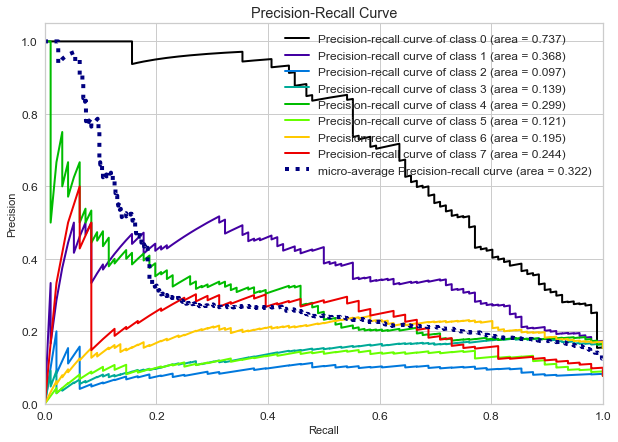

In [33]:
print_precrecCurve(cclf,X_test,y_test)

In [30]:
support_vectors_pca = pca.transform(clf.support_vectors_)

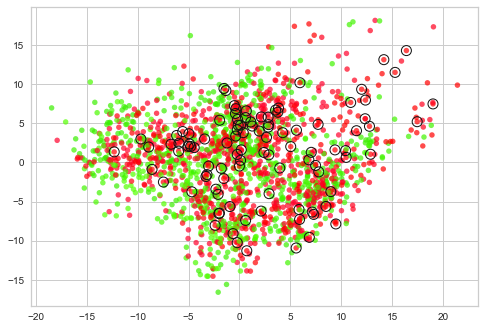

In [34]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, 
            cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
plt.show()

Faccio Unbalanced Learning + Feature selection

In [35]:
from imblearn.under_sampling import TomekLinks
from collections import Counter

In [36]:
from sklearn.tree import DecisionTreeClassifier



In [37]:
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 261, 3: 255, 1: 251, 6: 250, 4: 249, 5: 140, 2: 128, 7: 128})


In [38]:
from sklearn.feature_selection import RFE
sel = RFE(DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20), n_features_to_select=22)
X_train_sel = sel.fit_transform(X_res, y_res)
print(f" DT New dimension: {X_train_sel.shape}")
X_test_sel = sel.transform(X_test)

 DT New dimension: (1662, 22)


In [252]:
#print(grid.best_params_)

              precision    recall  f1-score   support

           0       0.66      0.72      0.69        96
           1       0.53      0.73      0.61        96
           2       0.45      0.50      0.48        48
           3       0.62      0.38      0.47        96
           4       0.47      0.42      0.44        96
           5       0.40      0.69      0.50        48
           6       0.51      0.31      0.39        96
           7       0.53      0.54      0.54        48

    accuracy                           0.53       624
   macro avg       0.52      0.54      0.51       624
weighted avg       0.54      0.53      0.52       624



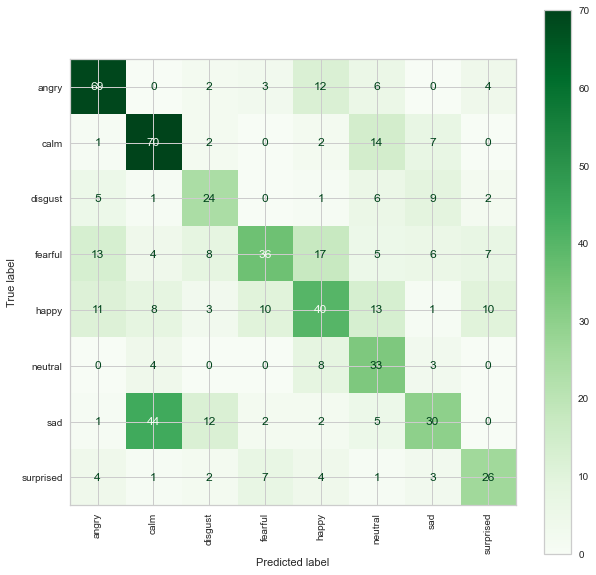

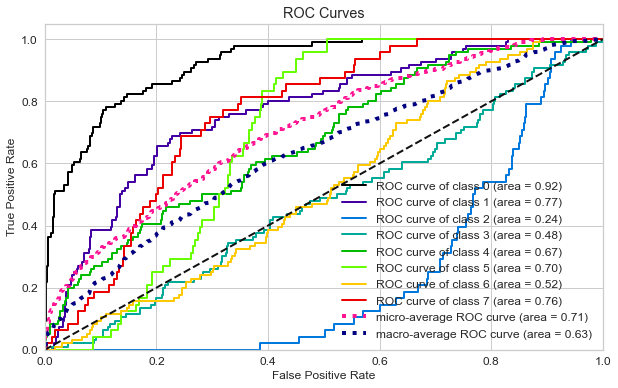

In [47]:
clf = svm.SVC(C = 0.1  , kernel = 'linear', tol = 1.0,decision_function_shape='ovo')
clf.fit(X_train_sel, y_res)
y_pred = clf.predict(X_test_sel)
print(classification_report(y_test,y_pred))
print_confMatrix(y_test,y_pred)
cclf = CalibratedClassifierCV(base_estimator=clf, cv=5)
cclf.fit(X_train_sel, y_res)
y_pred = cclf.predict(X_test_sel)
print_rocCurve(cclf,X_test_sel,y_test)

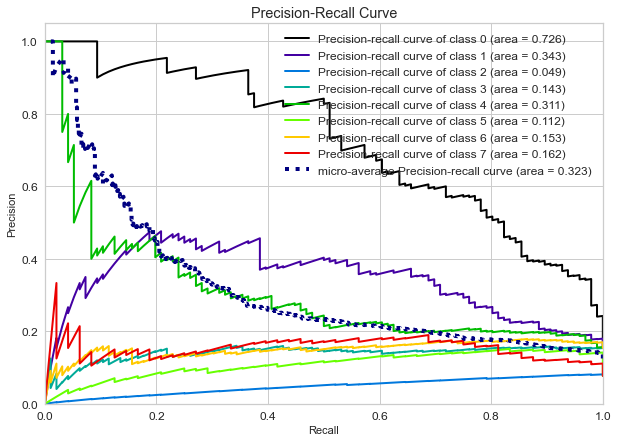

In [41]:
print_precrecCurve(cclf,X_test_sel,y_test)

In [42]:
pca = PCA(n_components=2)
pca.fit(X_train_sel)
X_pca = pca.transform(X_train_sel)

In [43]:
support_vectors_pca = pca.transform(clf.support_vectors_)

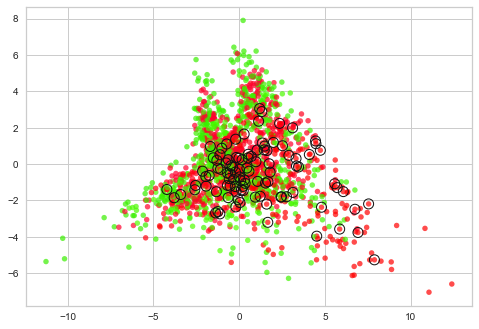

In [44]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, 
            cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
plt.show()

FACCIO LE ROC CURVE DI TUTTO 

In [64]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)


(624, 8)

In [86]:
from itertools import combinations

pair_list = list(combinations(np.unique(y) , 2))
print(pair_list)
y_score =  cclf.fit(X_train, y_train).predict_proba(X_test)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 4), (3, 5), (3, 6), (3, 7), (4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7)]


In [72]:
from sklearn.metrics import roc_auc_score

macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovo",
    average="macro",
)

print(f"Macro-averaged One-vs-OneROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.69


In [73]:
from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-One ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-One ROC AUC score:
0.73


In [90]:
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(8):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= 8

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")


Macro-averaged One-vs-Rest ROC AUC score:
0.69


In [77]:
from sklearn.metrics import RocCurveDisplay

In [80]:
le.classes_

array(['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad',
       'surprised'], dtype=object)

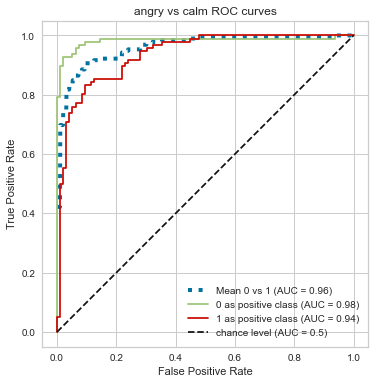

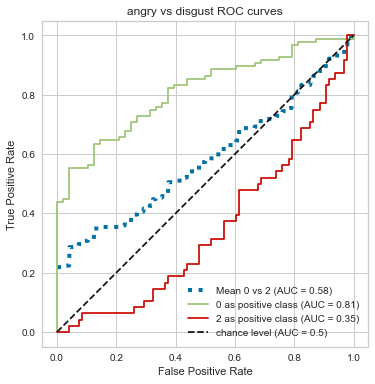

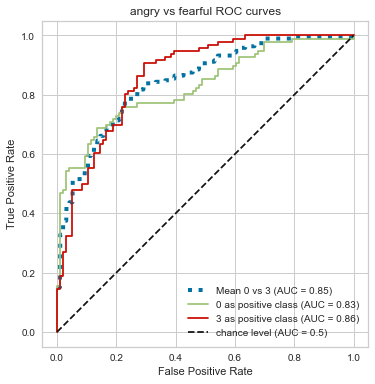

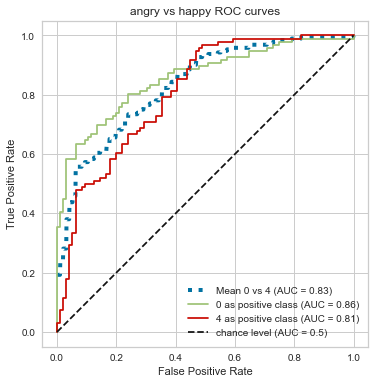

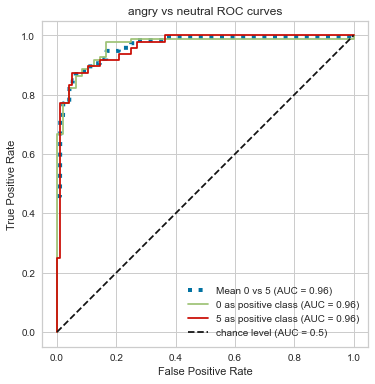

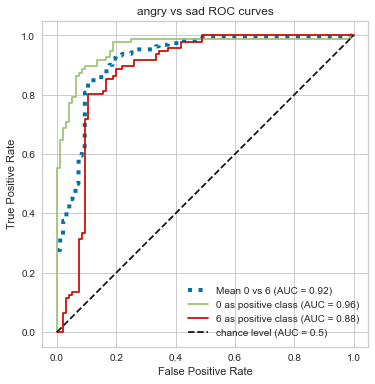

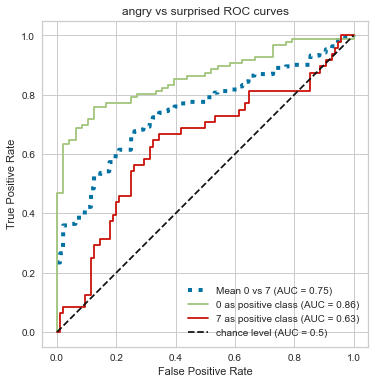

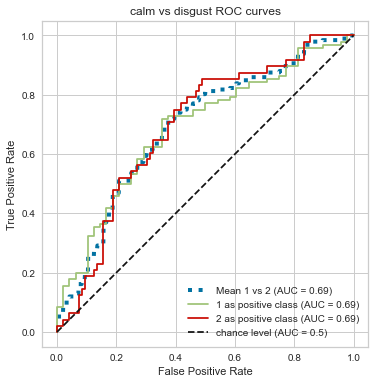

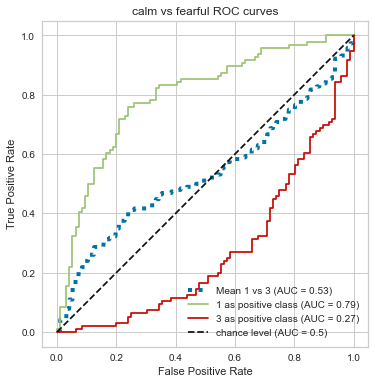

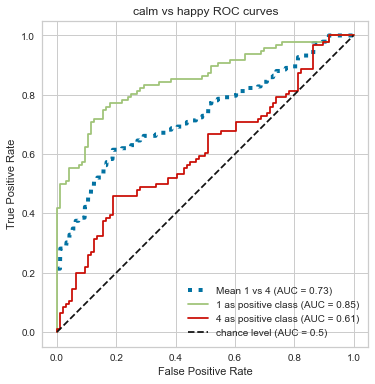

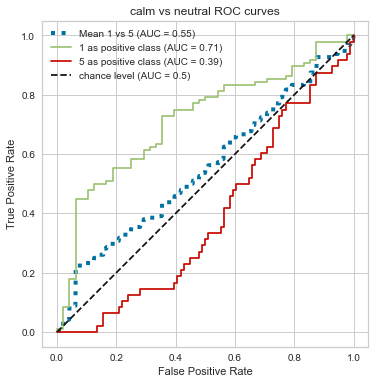

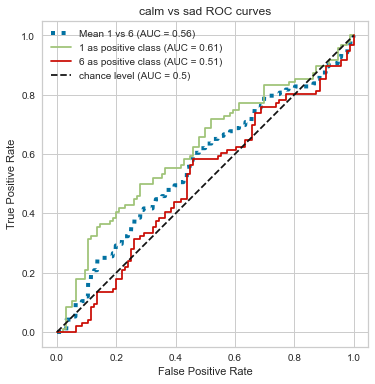

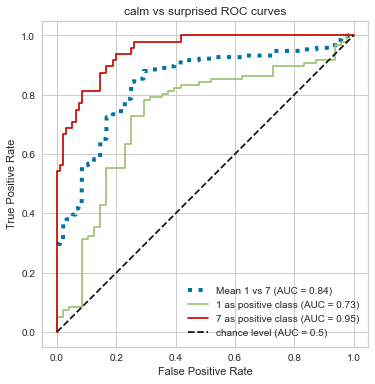

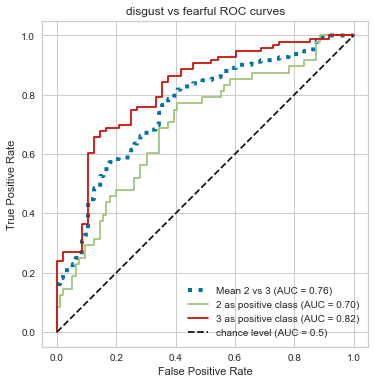

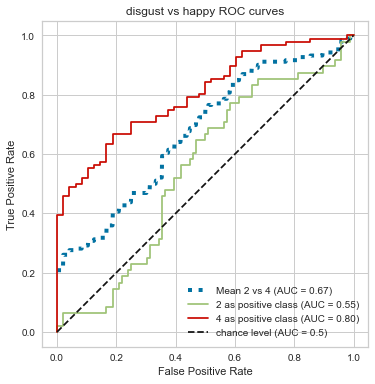

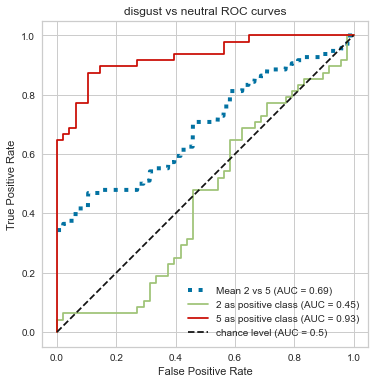

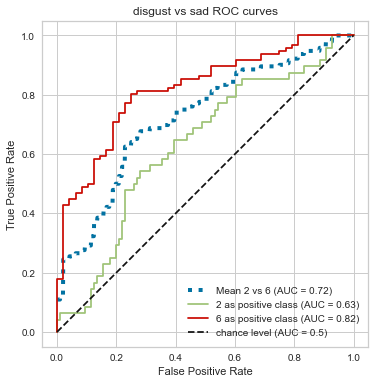

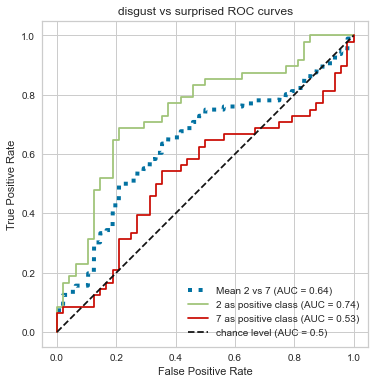

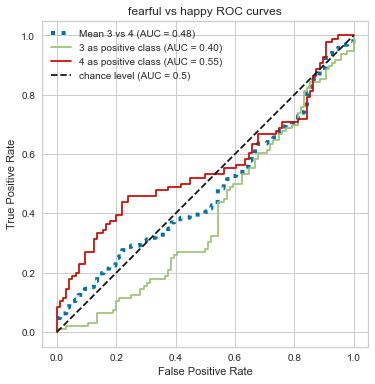

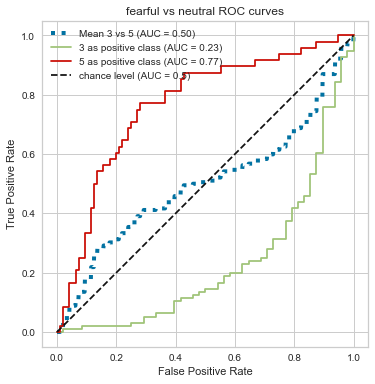

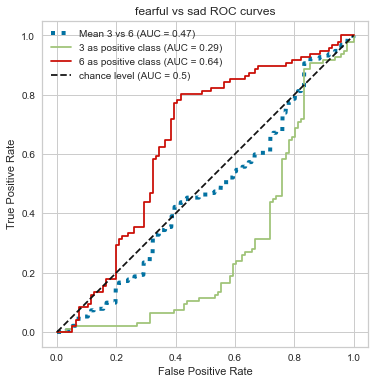

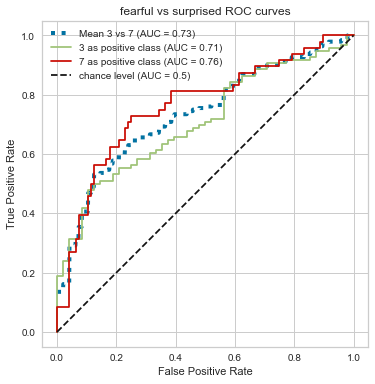

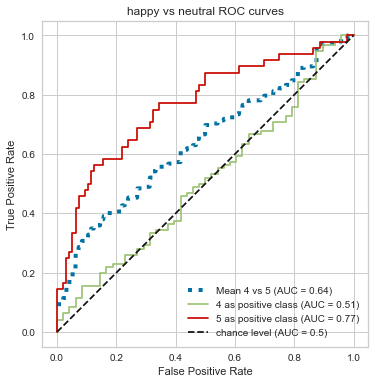

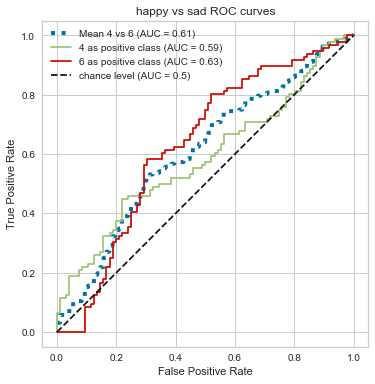

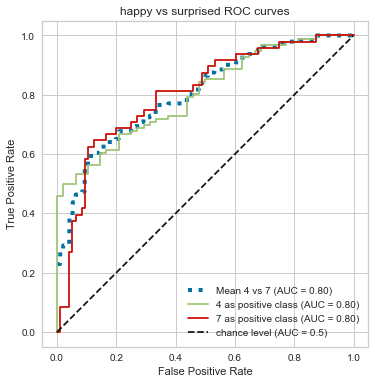

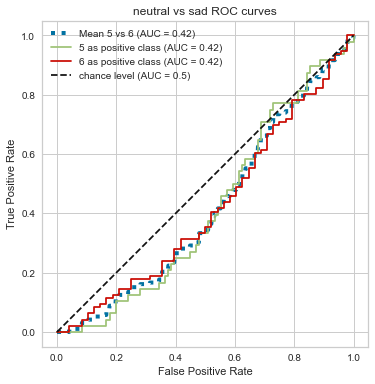

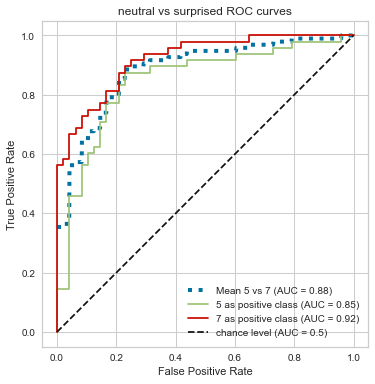

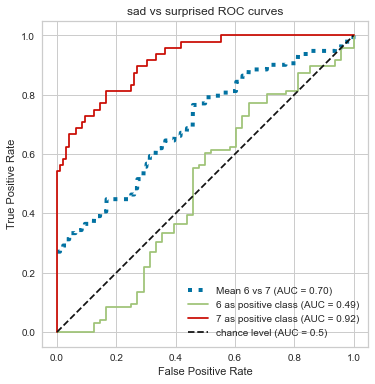

Macro-averaged One-vs-One ROC AUC score:
0.69


In [89]:
pair_scores = []
mean_tpr = dict()

for ix, (label_a, label_b) in enumerate(pair_list):

    a_mask = y_test == label_a
    b_mask = y_test == label_b
    ab_mask = np.logical_or(a_mask, b_mask)

    a_true = a_mask[ab_mask]
    b_true = b_mask[ab_mask]

    idx_a = np.flatnonzero(label_binarizer.classes_ == label_a)[0]
    idx_b = np.flatnonzero(label_binarizer.classes_ == label_b)[0]

    fpr_a, tpr_a, _ = roc_curve(a_true, y_score[ab_mask, idx_a])
    fpr_b, tpr_b, _ = roc_curve(b_true, y_score[ab_mask, idx_b])

    mean_tpr[ix] = np.zeros_like(fpr_grid)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
    mean_tpr[ix] /= 2
    mean_score = auc(fpr_grid, mean_tpr[ix])
    pair_scores.append(mean_score)

    fig, ax = plt.subplots(figsize=(6, 6))
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {label_a} vs {label_b} (AUC = {mean_score :.2f})",
        linestyle=":",
        linewidth=4,
    )
    RocCurveDisplay.from_predictions(
        a_true,
        y_score[ab_mask, idx_a],
        ax=ax,
        name=f"{label_a} as positive class",
    )
    RocCurveDisplay.from_predictions(
        b_true,
        y_score[ab_mask, idx_b],
        ax=ax,
        name=f"{label_b} as positive class",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{le.classes_[idx_a]} vs {le.classes_[label_b]} ROC curves")
    plt.legend()
    plt.show()

print(f"Macro-averaged One-vs-One ROC AUC score:\n{np.average(pair_scores):.2f}")

In [50]:
tmp=[8,249,292,308,309,311,382,554,832,1247,1283,1358,1481,1492,1702,1703,1704,1756,1757,1758,1801]

df_train.drop(tmp,axis=0)

,vocal_channel,emotion,emotional_intensity,statement,repetition,sex,mean,q25,q50,q75,...,sc_skew_w4,stft_sum_w4,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_kur_w4,stft_skew_w4
0,1,5,0,1,0,1,0.018034,0.603864,-0.063106,-0.76930,...,-4.354785,0.161158,-0.925138,2.167997,1.515260,1.079945,0.690192,0.036057,9.400360,-3.035005
1,1,5,0,1,1,1,0.013950,0.603864,-0.063106,-0.76930,...,-0.659640,-0.173413,1.908839,1.610931,0.996435,0.639413,0.409754,0.036057,-0.186504,0.434538
2,1,5,0,0,0,1,0.018855,0.622665,-0.063106,-0.76930,...,-3.086640,-0.286208,-0.925138,1.285119,1.118715,0.877776,0.722854,0.036057,2.891302,-1.463754
3,1,5,0,0,1,1,0.018087,0.603864,-0.063106,-0.76930,...,-0.396009,-0.588962,1.429546,1.176485,0.899140,0.723117,0.560400,0.036057,-0.049566,-0.052845
4,1,1,0,1,0,1,0.015921,0.603864,-0.063106,-0.76930,...,-0.624456,0.170902,0.987370,1.346235,1.065980,0.761301,0.452031,0.036057,0.878701,-0.532241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823,1,7,0,0,1,0,-0.019175,0.622665,-0.063106,-0.74864,...,-1.106246,-0.612427,-0.925138,-1.198817,0.514836,0.503321,0.647428,0.036057,1.054354,-1.526104
1824,1,7,1,1,0,0,-0.016770,0.603864,-0.063106,-0.74864,...,-0.901054,-0.871550,-0.925138,-1.198817,-0.484862,0.298852,0.734806,0.036057,-0.389173,-0.504115
1825,1,7,1,1,1,0,-0.025751,0.622665,-0.063106,-0.74864,...,-1.106898,-0.894085,-0.925138,-0.618677,-0.058185,0.167249,0.624605,0.036057,-0.130100,-0.454243
1826,1,7,1,0,0,0,-0.009914,0.603864,-0.063106,-0.70732,...,-0.732249,-0.424644,-0.925138,-1.198817,0.165989,0.375767,0.343780,0.036057,0.072917,-1.058564


In [51]:
col=[x for x in df_train.columns if x!="emotion"]
X_train=df_train[col].values
y_train = df_train["emotion"].values

In [52]:
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 261, 3: 255, 1: 251, 6: 250, 4: 249, 5: 140, 2: 128, 7: 128})


In [53]:
sel = RFE(DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20), n_features_to_select=22)
X_train_sel = sel.fit_transform(X_res, y_res)
print(f" DT New dimension: {X_train_sel.shape}")
X_test_sel = sel.transform(X_test)

 DT New dimension: (1662, 22)


              precision    recall  f1-score   support

           0       0.66      0.72      0.69        96
           1       0.53      0.73      0.61        96
           2       0.45      0.50      0.48        48
           3       0.62      0.38      0.47        96
           4       0.47      0.42      0.44        96
           5       0.40      0.69      0.50        48
           6       0.51      0.31      0.39        96
           7       0.53      0.54      0.54        48

    accuracy                           0.53       624
   macro avg       0.52      0.54      0.51       624
weighted avg       0.54      0.53      0.52       624



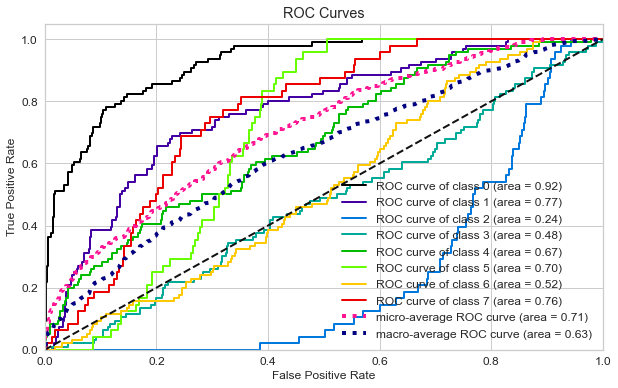

In [59]:
clf = SVC(C = 0.1  , kernel = 'linear', tol = 1.0,decision_function_shape='ovo')
clf.fit(X_train_sel, y_res)
y_pred = clf.predict(X_test_sel)
print(classification_report(y_test,y_pred))
cclf = CalibratedClassifierCV(base_estimator=clf, cv=5)
cclf.fit(X_train_sel, y_res)
y_pred = cclf.predict(X_test_sel)
print_rocCurve(cclf,X_test_sel,y_test)

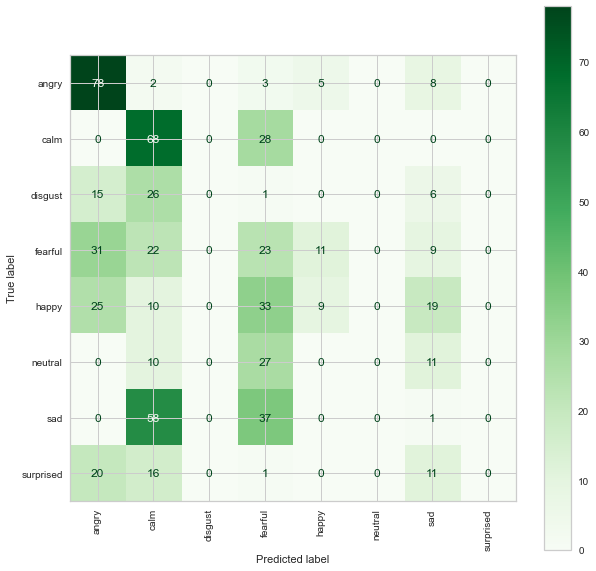

In [60]:
print_confMatrix(y_test,y_pred)

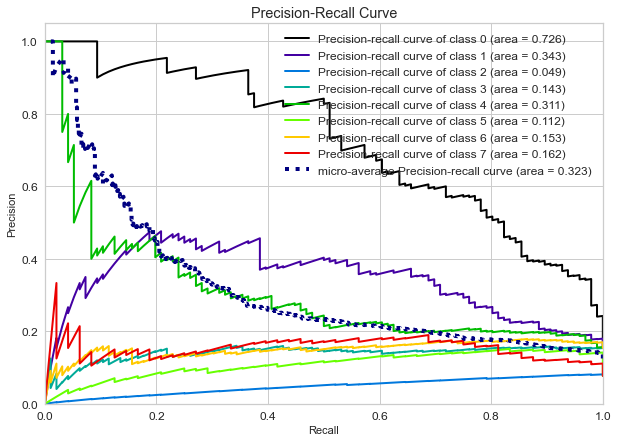

In [61]:
print_precrecCurve(cclf,X_test_sel,y_test)